# NDP Song Lyric Generation (using RNN LSTM)

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

## Import dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.12
Tensorflow version: 2.6.3
Keras version: 2.6.0


## Download the dataset

In [2]:
dataset_file_names = os.listdir('../input/ndp-songs/NDP Song Lyrics')
dataset_file_names[:5]

['Someone Someday.txt',
 'I Love Singapore.txt',
 'We Will Get There.txt',
 'Shine for Singapore.txt',
 'Theres No Place Id Rather Be.txt']

In [3]:
corpus = ''
for file in dataset_file_names:
    text = open('../input/ndp-songs/NDP Song Lyrics/'+file, mode='r').read()
    corpus += text

## Analyze the dataset

In [4]:
print('Length of Corpus: {} characters'.format(len(corpus)))

Length of Corpus: 46154 characters


In [5]:
# Take a look at the first 250 characters in text.
print(corpus[:1000])

Didn't they used to say we're ordinary
Didn't we take it as that and put ourselves down
Don't we all, don't we all think it's necessary
To prove to them that we'll be
We'll be someone someday
Aren't you tired, so very tired of waiting
For something else, someone else to give us a hand
Pick yourself up, pick yourself up, get ready
We'll go make a difference
We'll be someone someday
That's right, we'll make you proud of us
You and me
That means that we should be happy
Let it come to us naturally
Look around, look around us
Weren't there many 
who patronised, contradict us and pushed us aside
Recognise, realise, start believing
Sure, there'll be despair
But don't let yourself fallIt's now a quarter of a century
We have worked so hard now just to be free
Through all the heartaches and the pains
We have stood through all the many many changes
In our hearts we have become like family
Can't you see
Yeah, can't you see
Ooh
We have only what we have in our hands
And in our hearts we've given wh

In [6]:
# The unique characters in the file
vocab = sorted(set(corpus))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

72 unique characters
vocab: ['\n', ' ', '!', '&', "'", '(', ')', ',', '-', '.', '1', '2', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '[', ']', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\u2005', '’', '…', '\u205f']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [7]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '&' :   3,
  "'" :   4,
  '(' :   5,
  ')' :   6,
  ',' :   7,
  '-' :   8,
  '.' :   9,
  '1' :  10,
  '2' :  11,
  ':' :  12,
  ';' :  13,
  '?' :  14,
  'A' :  15,
  'B' :  16,
  'C' :  17,
  'D' :  18,
  'E' :  19,
  ...
}


In [8]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '&' "'" '(' ')' ',' '-' '.' '1' '2' ':' ';' '?' 'A' 'B' 'C'
 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U'
 'V' 'W' 'Y' '[' ']' '^' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l'
 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '\u2005' '’' '…'
 '\u205f']


In [9]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in corpus])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 46154
'Ever since we c' --> array([18, 50, 45, 55,  4, 61,  1, 61, 49, 46, 66,  1, 62, 60, 46])


## Create training sequences

In [10]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 50
examples_per_epoch = len(corpus) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 904


In [11]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

D
i
d
n
'


2022-05-23 08:39:30.843279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 08:39:30.975422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 08:39:30.976220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-23 08:39:30.979257: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 904

"Didn't they used to say we're ordinary\nDidn't we ta"
"ke it as that and put ourselves down\nDon't we all, "
"don't we all think it's necessary\nTo prove to them "
"that we'll be\nWe'll be someone someday\nAren't you t"
'ired, so very tired of waiting\nFor something else, '


In [13]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [14]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [15]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

2022-05-23 08:39:34.128367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


dataset size: 904


In [16]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 50
Target sequence size: 50

Input: "Didn't they used to say we're ordinary\nDidn't we t"
Target: "idn't they used to say we're ordinary\nDidn't we ta"


In [17]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [18]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('D')
  expected output: 50 ('i')
Step  1
  input: 50 ('i')
  expected output: 45 ('d')
Step  2
  input: 45 ('d')
  expected output: 55 ('n')
Step  3
  input: 55 ('n')
  expected output: 4 ("'")
Step  4
  input: 4 ("'")
  expected output: 61 ('t')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [19]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 50), (64, 50)), types: (tf.int64, tf.int64)>

In [20]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 14


In [21]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[59  1 64 ... 37 46  1]
 [61 42 52 ... 55 45 60]
 [46  0 27 ...  1 47 56]
 ...
 [49 46  1 ... 46  0 16]
 [54 42 52 ...  1 64 50]
 [61 49 46 ...  1 42 55]], shape=(64, 50), dtype=int64)

1st batch: target_text: tf.Tensor(
[[ 1 64 46 ... 46  1 59]
 [42 52 46 ... 45 60  1]
 [ 0 27 66 ... 47 56 59]
 ...
 [46  1 60 ...  0 16 62]
 [42 52 46 ... 64 50 53]
 [49 46  1 ... 42 55 45]], shape=(64, 50), dtype=int64)


In [22]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [23]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[3 2 0 7 4 9 7 0]
 [2 2 4 8 4 5 4 4]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.02907702 -0.04061138  0.04452899 -0.02478867 -0.03528936]
  [-0.04809432  0.02356852 -0.04368475 -0.00144722  0.0163223 ]
  [ 0.01255244  0.01990649  0.00175893 -0.04542438  0.03040084]
  [-0.03431685 -0.02688565 -0.02497016 -0.01997313  0.04952464]
  [ 0.04077509  0.01651292  0.03645304 -0.02172155 -0.0263918 ]
  [-0.04551123  0.03373984 -0.0110838   0.04143575 -0.01737805]
  [-0.03431685 -0.02688565 -0.02497016 -0.01997313  0.04952464]
  [ 0.01255244  0.01990649  0.00175893 -0.04542438  0.03040084]]

 [[-0.04809432  0.02356852 -0.04368475 -0.00144722  0.0163223 ]
  [-0.04809432  0.02356852 -0.04368475 -0.00144722  0.0163223 ]
  [ 0.04077509  0.01651292  0.03645304 -0.02172155 -0.0263918 ]
  [-0.01570405  0.0413836   0.01211346  0.0075134   0.0335449 ]
  [ 0.04077509  0.01651292  0.03645304 -0.02172155 -0.0263918 ]
  [-0.04560341  0.00917456 

In [24]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [25]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [26]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           18432     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 72)            73800     
Total params: 5,339,208
Trainable params: 5,339,208
Non-trainable params: 0
_________________________________________________________________


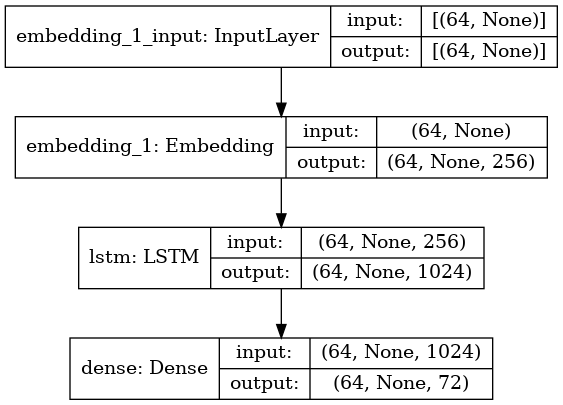

In [28]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Try the model

In [29]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


2022-05-23 08:39:39.402864: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(64, 50, 72) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [30]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 3.4286914e-04 -7.0970890e-04 -1.8843340e-03  1.3587663e-03
  2.0607812e-03 -1.9137338e-03  3.7788774e-03  1.2951236e-03
 -8.3451504e-03  7.0643574e-03 -1.5798046e-03  3.0917618e-03
  3.0413009e-03  3.4555472e-03 -2.1191796e-03 -6.2189612e-04
 -9.7300031e-04  1.5206985e-03 -5.0611068e-03 -2.9033830e-03
 -1.4781738e-03 -1.2032903e-03 -6.3025570e-03 -2.3691647e-03
 -4.2372448e-03  3.7622254e-03 -1.3424564e-03  1.8094911e-03
  8.3191163e-04 -1.9841667e-03  3.9063999e-04  9.8453253e-05
  9.6485019e-07 -1.4414068e-03 -3.0653870e-03  1.0982149e-03
 -2.4784927e-04  1.2783397e-03 -2.8680810e-03  1.5567864e-03
  3.4941686e-03 -1.2138329e-03 -4.6627419e-03  1.7158947e-03
  1.2707440e-03  1.6377692e-04  1.4980047e-03  1.0535447e-04
 -6.8296614e-04 -2.9475382e-04 -5.9443498e-03  1.8273829e-03
 -6.6252444e-03 -2.9879571e-03  5.6220358e-03 -1.7000287e-03
  3.6486653e-03 -7.5566745e-04 -4.6120072e-03 -2.2988063e-03
 -4.2275265e-03 -

In [31]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 0 0 2 2]], shape=(1, 5), dtype=int64)


In [32]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([50, 1])

In [33]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(50,)

In [34]:
sampled_indices

array([47, 31, 23, 44,  0, 18, 32,  5, 50, 44, 11, 21, 55, 61, 26, 47, 45,
       23,  2, 51, 58,  2, 56,  7, 15, 65, 19, 56, 64, 63,  9, 28, 38,  5,
       25, 20, 36, 22, 70,  6, 32, 49, 16, 53, 62, 14, 11, 27, 28, 36])

In [35]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 '\nNo matter where you may go\nYou know my heart will'

Next char prediction:
 'fQIc\nDR(ic2GntLfdI!jq!o,AxEowv.NY(KFVH…)RhBlu?2MNV'


In [36]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 0 ('\n')
  next predicted: 61 ('f')
Prediction  1
  input: 28 ('N')
  next predicted: 61 ('Q')
Prediction  2
  input: 56 ('o')
  next predicted: 61 ('I')
Prediction  3
  input: 1 (' ')
  next predicted: 61 ('c')
Prediction  4
  input: 54 ('m')
  next predicted: 61 ('\n')


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [37]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 50, 72)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.278083


In [38]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [39]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [40]:
EPOCHS=100

In [41]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/100
14/14 [==============================] - 2s 27ms/step - loss: 3.8056
Epoch 2/100
14/14 [==============================] - 0s 27ms/step - loss: 3.1288
Epoch 3/100
14/14 [==============================] - 0s 28ms/step - loss: 3.0286
Epoch 4/100
14/14 [==============================] - 1s 29ms/step - loss: 2.9106
Epoch 5/100
14/14 [==============================] - 0s 27ms/step - loss: 2.7608
Epoch 6/100
14/14 [==============================] - 1s 29ms/step - loss: 2.6012
Epoch 7/100
14/14 [==============================] - 0s 27ms/step - loss: 2.4569
Epoch 8/100
14/14 [==============================] - 0s 27ms/step - loss: 2.3505
Epoch 9/100
14/14 [==============================] - 0s 27ms/step - loss: 2.2693
Epoch 10/100
14/14 [==============================] - 0s 27ms/step - loss: 2.2127
Epoch 11/100
14/14 [==============================] - 0s 27ms/step - loss: 2.1612
Epoch 12/100
14/14 [==============================] - 0s 27ms/step - loss: 2.1120
Epoch 13/100
14/14 [=====

In [42]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

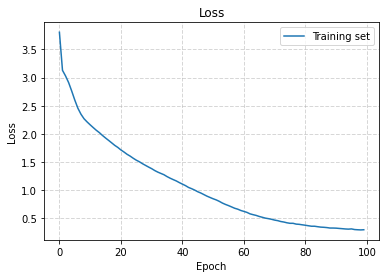

In [43]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [44]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_100'

In [45]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            18432     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 72)             73800     
Total params: 5,339,208
Trainable params: 5,339,208
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [47]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [48]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"Singapore ", num_generate=100))

Singapore strong and free
We have a grateful for
So come and sing
Sing a song strong and freeIt’s thery and br


In [49]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"Singapore ", temperature=1.5))

Singapore story
Is, we hell 1
So you, a, we belong.
Nothing in this world cano
One pass in the sun
With our hourss on
Reled un drarmHomeRauny
Pabildreaporeifu heartborid together everybodd the lis forevoreRead we've city
Kyon this is where we are Singapore
We're a nation't thy flees of your goals stand
And ievery shories Lew berstace, where nen't really stays be unizerI we are Singapore
Stand uprow we'lld a hopebe and pis
Bet a spree e ve
It'll be that we won’t be thI kincows worldI't Make it, but we win
Whis is prepared the day ways
Warm sunfuthe it, as one big lawedpechibe
Andonpore
Fhere
Thate)
Oh, oh, oh, oh, oh, oh, oh)
Mabybond see
A prop ofavle march
It runIt stald, into my ho
A land op eOrustant, we will reach whe cryto yourself up, my grieMom, your getere Life,
Nothink in this land
We knew
Like the colours of ye, Lenadny
FleThere harplove andivion dreams, friend
One people, ore gration, duenporfelle
Mornizery sem
Compen falleve with the world what Singap
We make I havely Qushe

## Save the model

In [50]:
model_name = 'text_generation_shakespeare_rnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.